In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/iris/Iris.csv
/kaggle/input/iris/database.sqlite


![picture explaining the parts of a iris flower](https://media.istockphoto.com/vectors/common-flower-parts-vector-id1020359338?k=20&m=1020359338&s=612x612&w=0&h=npJhyxEILDaXs812jaZMXc8Tua36sRO3sadHRYNlgQ8=)
# Iris flower analysis
The purpose of this analysis is to understand which machine learning models perform well in the iris dataset and why it is so good for the beginners.
## Exploring and understanding our data:

In [2]:
df = pd.read_csv('../input/iris/Iris.csv')
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
df.shape

(150, 6)

In [4]:
df.columns

Index(['Id', 'SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm',
       'Species'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


![Image of how you measure a flower](https://www.researchgate.net/profile/Zhi-Gang-Zhao-2/publication/272514310/figure/fig1/AS:294815561469959@1447300915487/Trollius-ranunculoide-flower-with-measured-traits-doi101371-journalpone0118299g001.png)

The competition to get polinators make flowers mutate a lot to have the most attractive characteristics, by this way the characteristics that attracts them are the ones that are the more selected, also this make some flowers species look like others of the same gender but have a few differences on measurements (like the iris gender)

<AxesSubplot:xlabel='Species', ylabel='count'>

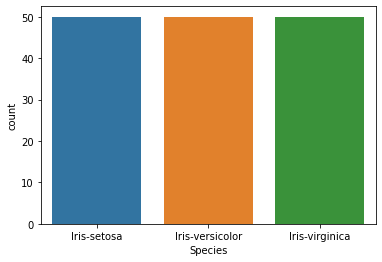

In [6]:
sns.countplot(x='Species', data=df)

In [7]:
df['Species'].value_counts()

Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: Species, dtype: int64

Fortunately our dataset is very balanced and every specie have 50 rows of data, also we don't have any null values.

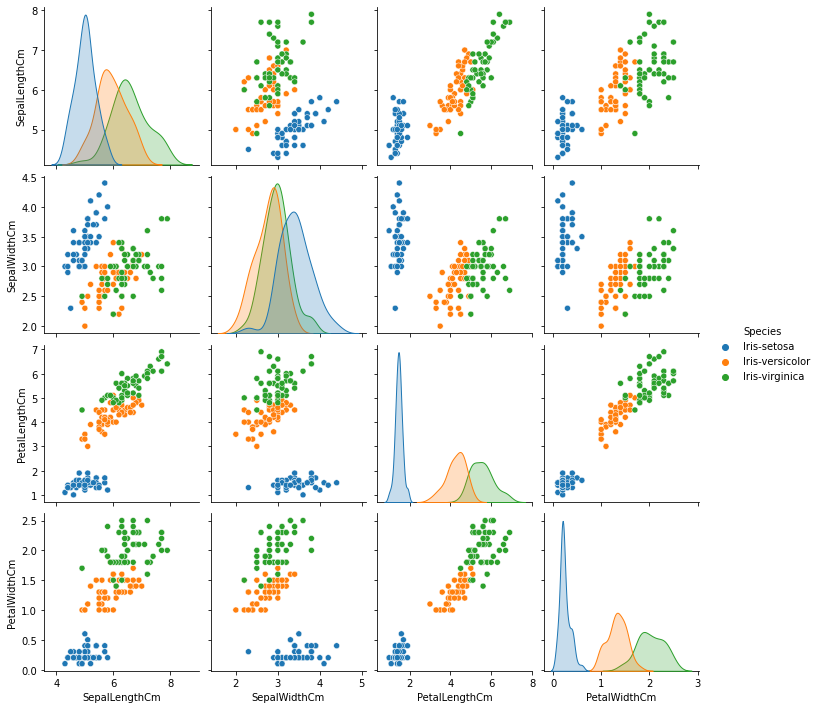

In [8]:
sns.pairplot(data=df.drop('Id', axis=1), hue='Species')

# Analysing correlation:

Text(0.5, 1.0, 'Correlation between variables and species')

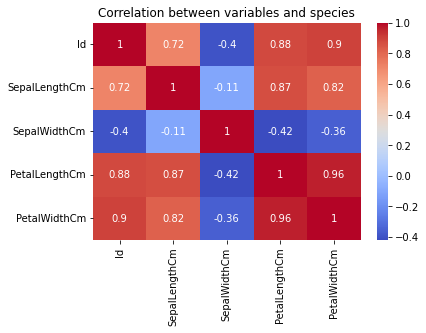

In [9]:
df_corr = df.corr()
sns.heatmap(data=df_corr, cmap='coolwarm', annot=True)
plt.title('Correlation between variables and species')

In [10]:
df = df.drop('Id', axis=1)
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


The Id column must be eliminated, since it can lead the model to a bias that values between a certain range are always of an specie (which means the model won't learn, it'll actually only memorize and become useless to a real use), the Id is probably used by the scientist only to control the data.

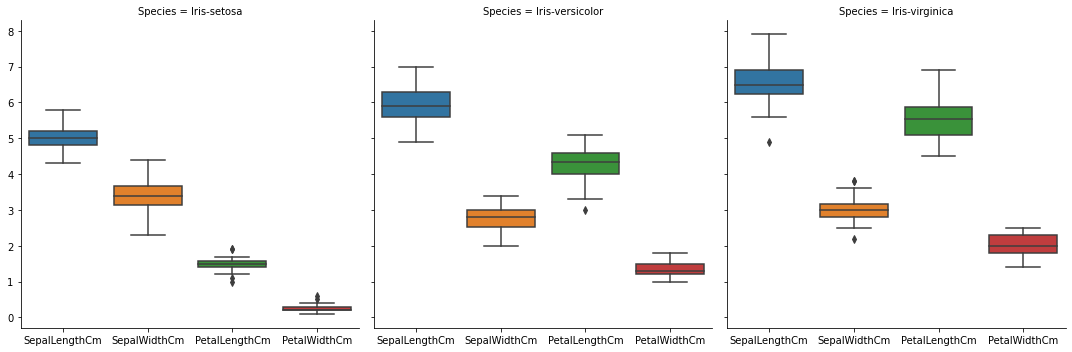

In [11]:
sns.catplot(data=df, col='Species', kind='box')

Isn't really difficult to tell which of them are the same species, since every Specie has a distinct combination of each Feature it is possible to get a high score with almost any model without actually using any data engineering technics.

# Creating the models:
In order to test our hipothesis we're going to try these models to solve this problem without changing any data:
1. Logistic regression
2. Decision Tree
3. SVC
4. Random Forest
5. KNN

in order to do that i made this class, that will train classification and models.

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

class model_evaluator:
    def __init__(self):
        #You can add more models here if you're curious
        self.models = [
            ('Logistic regression', LogisticRegression()),
            ('Decision tree', DecisionTreeClassifier()),
            ('SVC', SVC()),
            ('Random forest', RandomForestClassifier()),
            ('KNN', KNeighborsClassifier())
        ]
    
        self.cv_models = []
    
        self.predictions = []

        self.metrics = []
    
    def generate_metrics(self, name, model, X_test, y_test):
        self.cv_models.append((name, model))
        p = model.predict(X_test)
        
        #you can add more evaluation metrics in this dict here
        #y test are the correct values and p the predicted values
        d = {
            'Name': name,
            'accuracy': accuracy_score(y_test, p)
        }
        self.metrics.append(d)
    
    def evaluate_models(self, X_train, X_test, y_train, y_test):
        for name, model in self.models:
                
            model.fit(X_train, y_train.values.ravel())
            
            self.generate_metrics(name, model, X_test, y_test)

        self.models.extend(self.cv_models)    
            
        self.metrics = pd.DataFrame(self.metrics)
        
        self.metrics = self.metrics.set_index('Name').sort_values(by=['accuracy'], ascending=False)
    
    #This method returns the model that had the best R2 score in the evaluation
    def select_best_accuracy(self):
        best = self.metrics[self.metrics['r2 score'] == self.metrics['accuracy'].max()]
        print(best)
        for model in self.models:
            if model[0] == best.index:
                return model[1]


In [13]:
X = df.drop('Species', axis=1)
y = df['Species']

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

tester = model_evaluator()
tester.evaluate_models(X_train, X_test, y_train, y_test)

In [15]:
tester.metrics

,accuracy
Name,
Logistic regression,1.0
Decision tree,1.0
SVC,1.0
Random forest,1.0
KNN,1.0


# Conclusion:
The iris dataset seems like an "ideal world data", is very clean, already scaled and balanced, so this problem doesn't require data engineering skills, which makes it ideal for beginners.